# Predicting Customer Satisfaction Level from Santander 

This project is on the kaggle platform (link in cell below). The dataset is anonymized and consists of a large number of numeric variables.

https://www.kaggle.com/c/santander-customer-satisfaction

In [1]:
# Importing libraries and frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

## Importing dataset

In [ ]:
# Importing train data
df_train = pd.read_csv("data/train.csv")
df_train.head()

In [ ]:
# Importing test data
df_data_test = pd.read_csv("data/test.csv")
df_result_test = pd.read_csv("data/sample_submission.csv")
df_test = df_data_test.merge(df_result_test, on = 'ID')
df_test.head()

## Feature Engineering

In [ ]:
print(len(df_train))
print(len(df_test))

In [ ]:
# Saving columns names and modifing it
original_col_names = df_train.columns

In [ ]:
# Setting new columns names for to facilitate data manipulation.
new_col_names = ["ID"]
new_col_names = new_col_names + (["var" + str(i) for i in range(1,370)])
new_col_names = new_col_names + ["TARGET"]

df_train.columns = new_col_names
df_test.columns = new_col_names

As the number of characteristics is very large I applied the Principal Component Analysis algorithm to reduce the size of the dataset and facilitate the analyzes and transformations that precede the creation of the predictive model.

In [85]:
# Checking for missing values
print(pd.isna(df_train).any().any())
print(pd.isna(df_test).any().any())
print(pd.isnull(df_train).any().any())
print(pd.isnull(df_test).any().any())

False
False
False
False


I saved dataset before applying transformations. Then I dropped "ID" variable and converting all independent variables to float. So I got the features with a proportion of non-zero values greater than 60%.

In [78]:
# Saving dataset
df_train.to_csv("data/df_train.csv", index=False)
df_test.to_csv("data/df_test.csv", index=False)

### Removing duplicated features

I eliminated the duplicate columns applying drop_duplicates function to pandas in the transposed dataframe.

In [113]:
df_no_duplicate_train = df_train.T.drop_duplicates(keep='first').T
df_no_duplicate_test = df_test[list(df_no_duplicate_train.columns)]

### Applying more filters to features

Before filtering features, I normalized dataset.

In [115]:
normalizer = Normalizer()
df_normalized_train = pd.DataFrame(normalizer.fit_transform(df_no_duplicate_train.drop("ID", axis=1)),
                                  columns = df_no_duplicate_train.drop("ID", axis=1).columns)

normalizer = Normalizer()
df_normalized_test = pd.DataFrame(normalizer.fit_transform(df_no_duplicate_test.drop("ID", axis=1)),
                                  columns = df_no_duplicate_test.drop("ID", axis=1).columns)

df_normalized_train.to_csv("data/df_normalized_train.csv", index=False)
df_normalized_test.to_csv("data/df_normalized_test.csv", index=False)

In [15]:
# df_normalized_train = pd.read_csv("data/df_normalized_train.csv")
# df_normalized_test = pd.read_csv("data/df_normalized_test.csv")

### Removing constant and Quasi-Constant Features Using Variance Threshold

I removed constant and quasi-constant variables from my dataset using variance threshhold.

In [17]:
# Removing quasi-constant columns
constant_filter = VarianceThreshold(threshold=0.0001)
constant_filter.fit(df_normalized_train.drop("TARGET", axis=1))

filtered_columns = [column for column in df_normalized_train.drop("TARGET", axis=1).columns
                    if column not in df_normalized_train.drop("TARGET", axis=1) \
                    .columns[constant_filter.get_support()]]


df_filtered_train = df_normalized_train.drop(filtered_columns, axis=1)
df_filtered_test = df_normalized_test.drop(filtered_columns, axis=1)

In [122]:
df_filtered_train.shape

(76020, 42)

### Removing Highly Correlated Features

I removed the highly correlated independent features. I created a correlation matrix for filter low-correlated features.

In [20]:
correlation_matrix = df_filtered_train.drop("TARGET", axis=1).corr()
correlated_features = set()

[correlated_features.add(rowname) for rowname in correlation_matrix.columns for colname in correlation_matrix.columns if \
correlation_matrix.loc[rowname][colname] > 0.8 and rowname != colname]

df_filter_norm_train = df_filtered_train.drop(labels=correlated_features, axis=1)
df_filter_norm_test = df_filtered_test.drop(labels=correlated_features, axis=1)

In [21]:
df_filter_norm_train.to_csv("data/df_filter_norm_train.csv", index=False)
df_filter_norm_test.to_csv("data/df_filter_norm_test.csv", index=False)

In [24]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

In [25]:
df_reduced_train = df_train[list(df_filter_norm_train.columns)]
df_reduced_test = df_test[list(df_filter_norm_train.columns)]

In [26]:
df_reduced_train.to_csv("data/df_reduced_norm_train.csv", index=False)
df_reduced_test.to_csv("data/df_reduced_norm_test.csv", index=False)

## Exploratory Analysis

In this step I will perform exploratory data analysis after filtering.

### Univariate Analysis

In [27]:
df_reduced_train = pd.read_csv("data/df_reduced_norm_train.csv")
df_reduced_test = pd.read_csv("data/df_reduced_norm_test.csv")

###### Getting statistical measures

In [28]:
# describe for independents numerical features
df = df_reduced_train.drop("TARGET", axis=1)

df_describe = pd.concat([df.describe().T,
              df.mad().rename('mad'),
              df.skew().rename('skew'),
              df.kurt().rename('kurt'),
              df.median().rename('median')
              ], axis=1).T

display(df_describe)

,var1,var170,var183,var184,var201,var202,var225,var241,var242,var329,var330,var338,var342,var369
count,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,7.602000e+04,76020.000000,76020.000000,7.602000e+04
mean,-1523.199277,1.493682e+03,1.367967e+04,2.922910e+02,4.998685e+06,2.630887e+06,2823.949089,8.541207e+02,1.932954e+03,1579.135311,8.913659e+02,613.534443,556.184178,1.172358e+05
std,39033.462364,2.001649e+04,6.301408e+04,2.331640e+04,2.235230e+08,1.621798e+08,25334.468106,1.425589e+04,2.535572e+04,12148.452398,9.888597e+03,9292.752726,7182.642532,1.826646e+05
min,-999999.000000,0.000000e+00,-4.942260e+03,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000,0.000000e+00,0.000000e+00,-128.370000,-8.040000e+00,0.000000,0.000000,5.163750e+03
25%,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,6.787061e+04
50%,2.000000,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.000000,9.900000e-01,0.000000,0.000000,1.064092e+05
75%,2.000000,0.000000e+00,2.359950e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,90.000000,1.221750e+01,0.000000,0.000000,1.187563e+05
max,238.000000,1.500000e+06,3.458077e+06,6.119500e+06,1.000000e+10,1.000000e+10,840000.000000,1.155003e+06,2.310003e+06,812137.260000,1.542339e+06,668335.320000,304838.700000,2.203474e+07
mad,3047.176871,2.957499e+03,2.401170e+04,5.824793e+02,9.992372e+06,5.260389e+06,5523.441949,1.626148e+03,3.579028e+03,2745.337512,1.639598e+03,1208.446932,1093.003385,5.006402e+04
skew,-25.541574,2.253020e+01,1.188424e+01,2.395388e+02,4.469458e+01,6.162913e+01,12.460387,3.543599e+01,3.631893e+01,22.400752,7.003218e+01,28.710773,20.952578,5.127453e+01


###### Checking univariate features distributions

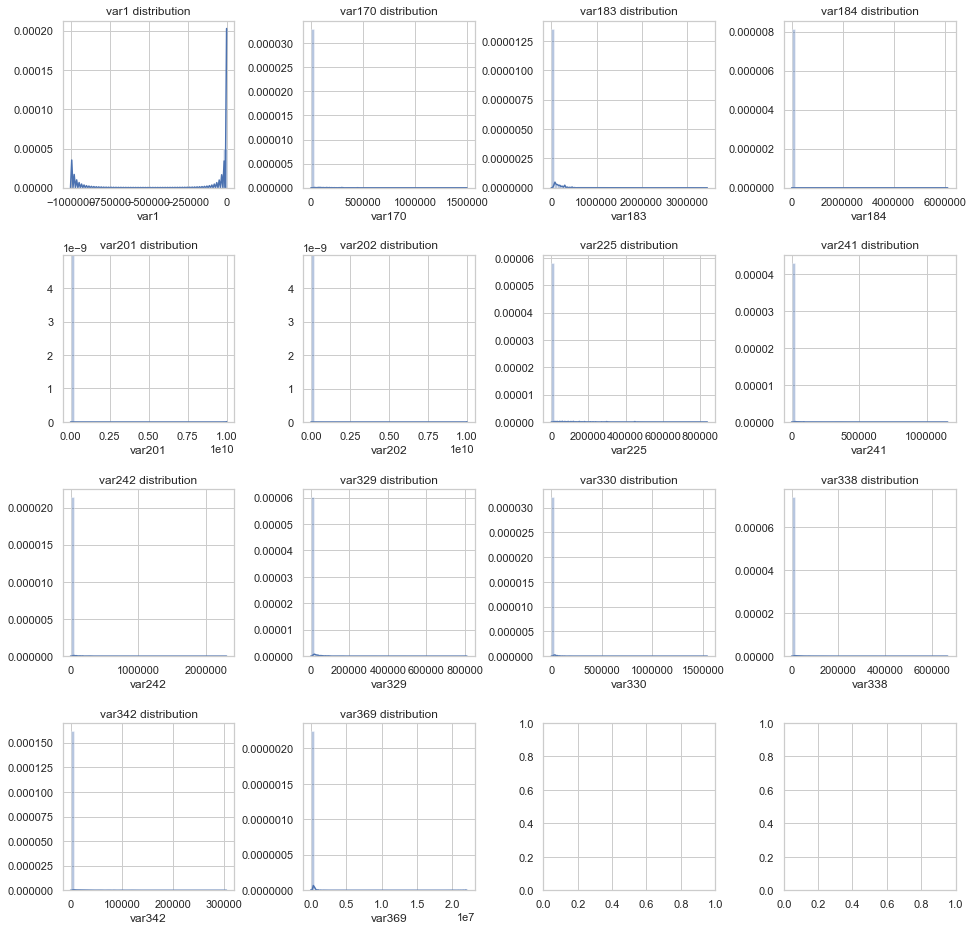

In [29]:
df = df_reduced_train.drop("TARGET", axis=1)
fig, axs = plt.subplots(ncols=4, nrows=4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(16, 16, forward=True)

count = 0

for i in range(4):
    for j in range(4):
        plt.sca(ax=axs[i][j])
        if count < 14:
            col = df.columns[count]
            sns.distplot(df[col]).set_title(col +' distribution')
        else:
            break
            
        count +=1

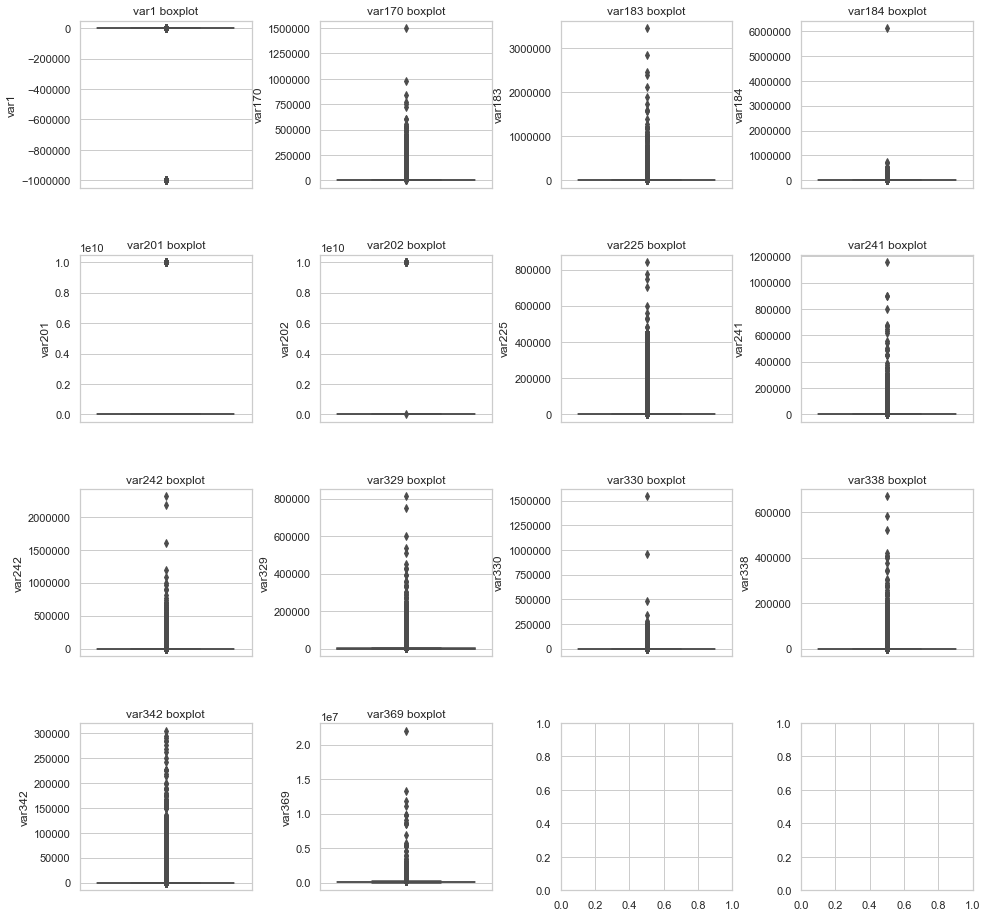

In [30]:
df = df_reduced_train.drop("TARGET", axis=1)
fig, axs = plt.subplots(ncols=4, nrows=4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(16, 16, forward=True)

count = 0

for i in range(4):
    for j in range(4):
        plt.sca(ax=axs[i][j])
        if count < 14:
            col = df.columns[count]
            sns.boxplot(y=df[col]).set_title(col +' boxplot')
        else:
            break
            
        count +=1

The data has many outliers, which make it difficult to respond to their distribution and treatment.

###### Searching for outliers

In [31]:
# Calculating variables z-score
df = df_reduced_train.drop("TARGET", axis=1)
z = np.abs(scipy.stats.zscore(df))

threshold = 3
print(np.where(z > 3))

(array([    4,     4,    13, ..., 76004, 76004, 76004]), array([ 7,  8,  7, ...,  2, 10, 11]))


###### Calculating interquartile range (IQR) for each column for outlier detection

In [32]:
# Getting IQR for each column
df = df_reduced_train.drop("TARGET", axis=1)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

var1          0.0000
var170        0.0000
var183      235.9950
var184        0.0000
var201        0.0000
var202        0.0000
var225        0.0000
var241        0.0000
var242        0.0000
var329       90.0000
var330       12.2175
var338        0.0000
var342        0.0000
var369    50885.6400
dtype: float64


In [33]:
# Printing outliers
print((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))

        var1  var170  var183  var184  var201  var202  var225  var241  var242  \
0      False   False   False   False   False   False   False   False   False   
1      False   False   False   False   False   False    True   False   False   
2      False   False   False   False   False   False   False   False   False   
3      False   False   False   False   False   False   False   False   False   
4      False   False    True   False   False   False   False    True    True   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
76015  False   False   False   False   False   False   False   False   False   
76016  False   False    True   False   False   False   False   False   False   
76017  False   False   False   False   False   False   False   False   False   
76018  False   False   False   False   False   False   False   False   False   
76019  False   False   False   False   False   False   False   False   False   

       var329  var330  var338  var342  

###### Treating outliers

Removing outliers

In [34]:
# Removing based on Z-score
df_train_zscore = df_reduced_train[(z < 3).all(axis=1)]

# Removing based on IQR
df_train_iqr = df_reduced_train[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

I checked clean train data distribution to validate outliers. 

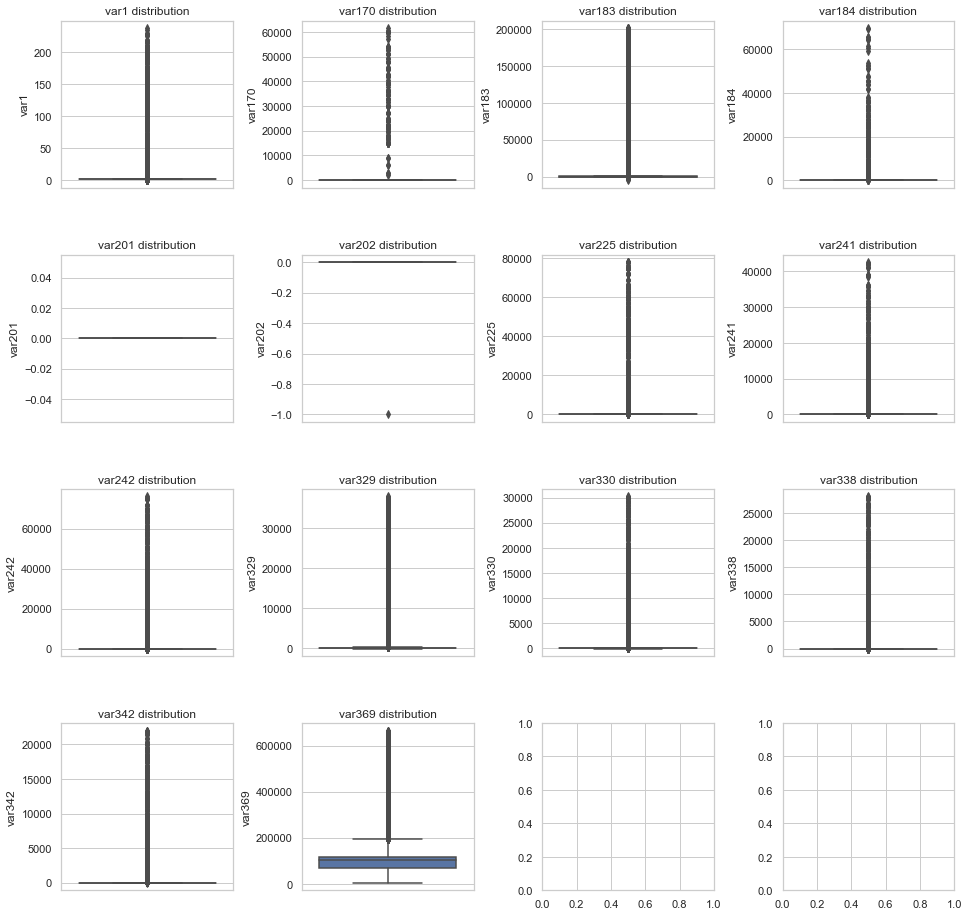

In [35]:
# Checking
fig, axs = plt.subplots(ncols=4, nrows=4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(16, 16, forward=True)
df = df_train_zscore

count = 0

for i in range(4):
    for j in range(4):
        plt.sca(ax=axs[i][j])
        if count < 14:
            col = df.columns[count]
            sns.boxplot(y=df[col]).set_title(col +' distribution')
        else:
            break
            
        count +=1

/home/naiara/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/naiara/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


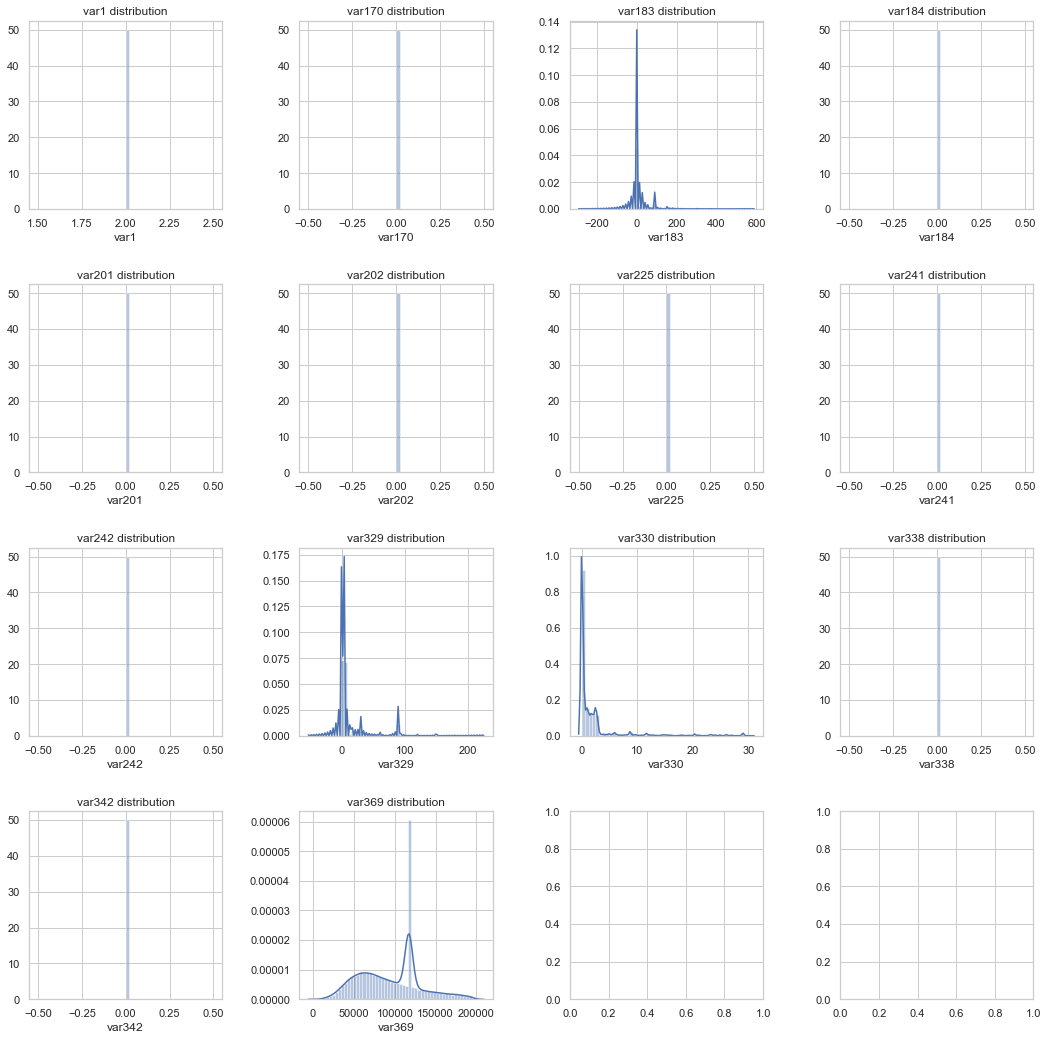

In [36]:
# Checking clean data distribution
fig, axs = plt.subplots(ncols=4, nrows=4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(18, 18, forward=True)
df = df_train_iqr

count = 0

for i in range(4):
    for j in range(4):
        plt.sca(ax=axs[i][j])
        if count < 14:
            col = df.columns[count]
            sns.distplot(df[col]).set_title(col +' distribution')
        else:
            break
            
        count +=1

I chose to work with IQR removal.

In [37]:
# Removing test data ouliers
df = df_reduced_test.drop("TARGET", axis=1)

# Getting IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_test_iqr = df_reduced_test[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Removing by z-score
# Calculating variables z-score
z = np.abs(scipy.stats.zscore(df))

threshold = 3
df_test_zscore = df_reduced_test[(z < 3).all(axis=1)]

In [38]:
df_train_zscore.to_csv("data/df_train_zscore.csv", index=False)
df_test_zscore.to_csv("data/df_test_zscore.csv", index=False)
df_train_iqr.to_csv("data/df_train_iqr.csv", index=False)
df_test_iqr.to_csv("data/df_test_iqr.csv", index=False)

In [39]:
df_train_iqr = pd.read_csv("data/df_train_iqr.csv")
df_test_iqr = pd.read_csv("data/df_test_iqr.csv")

Checking Target variable

Text(0.5, 1.0, 'TARGET barplot')

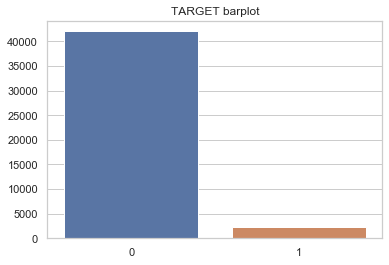

In [40]:
# TARGET variable barplot
sns.set(style="whitegrid")
sns.barplot(x=[0,1], y=df_train_iqr.TARGET.value_counts().values).set_title('TARGET barplot')

As noted in the graph, target variable is unbalanced.

### Bivariate Analysis

###### Checking correlation between variables

(15.5, 0.5)

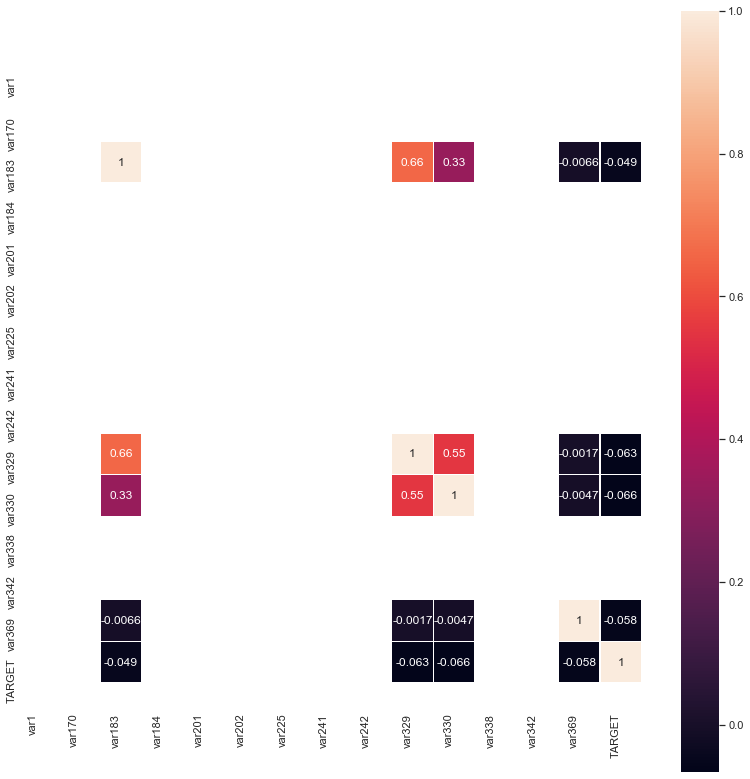

In [81]:
# heat map of correlation values
corr = df_train_iqr.corr()
fig, ax = plt.subplots(figsize=(14,14))

g = sns.heatmap(corr, annot=True, ax=ax, square=True, linewidth=0.5)

g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=90, horizontalalignment='left')
ax.set_ylim([len(corr) + 0.5, 0.5])

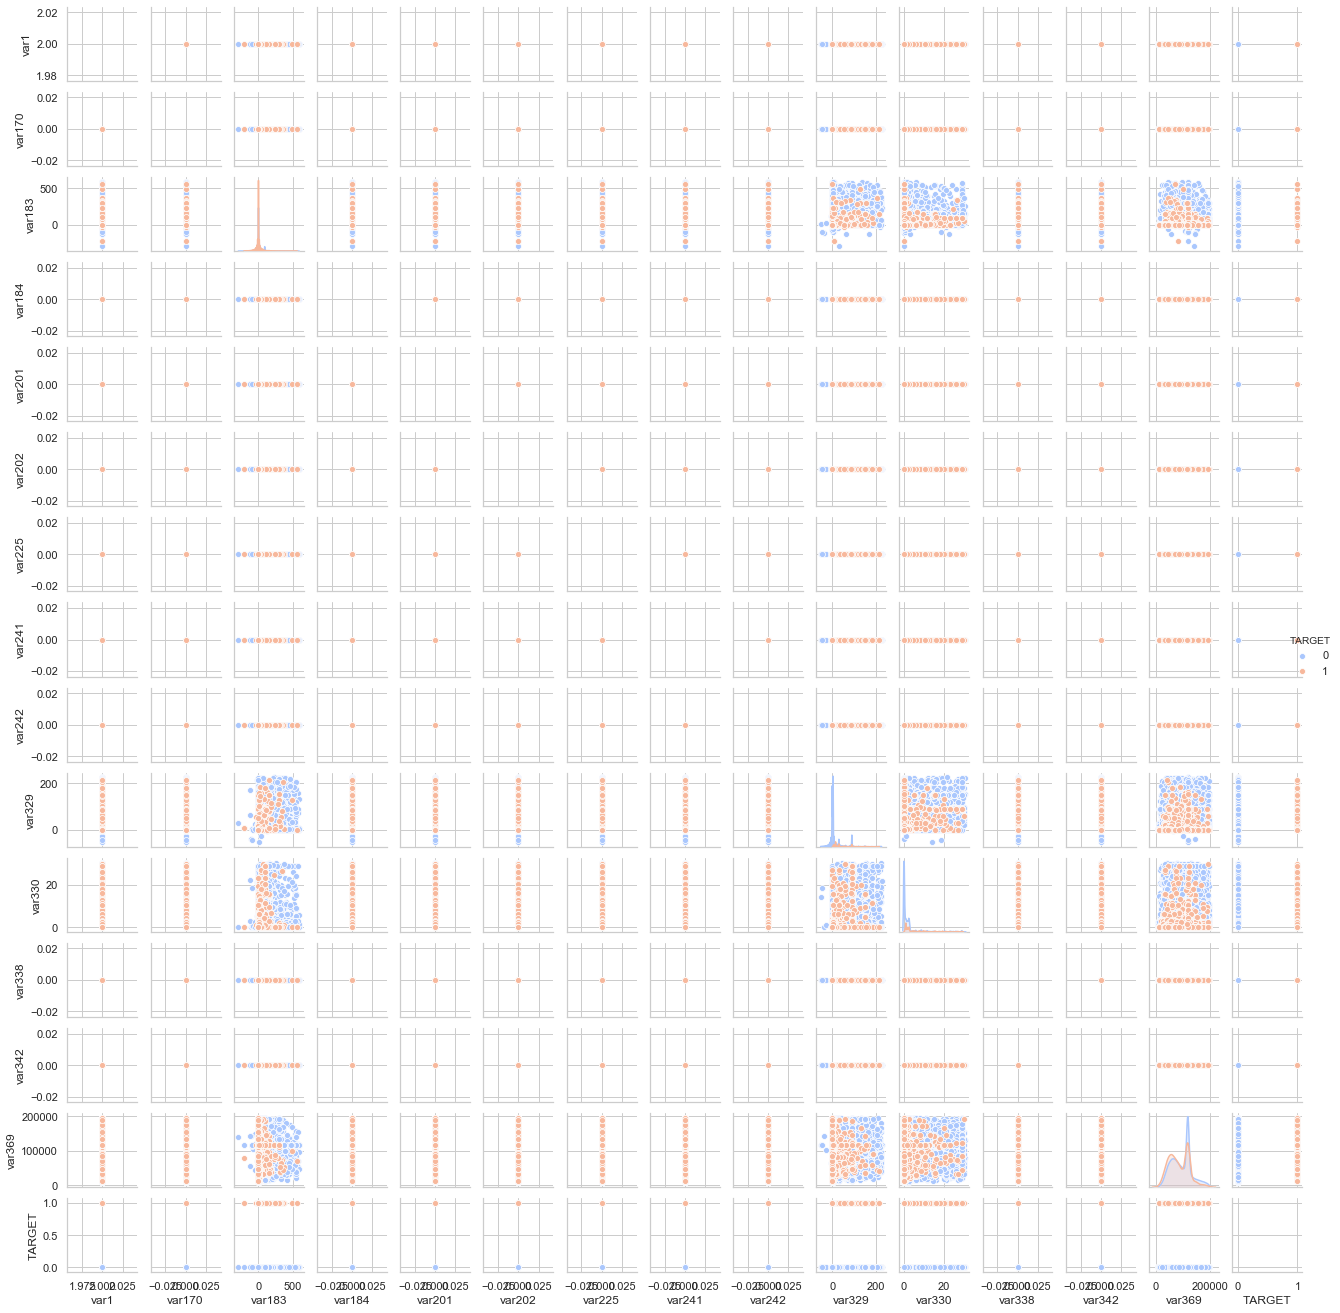

In [88]:
# pairplot matrix
g = sns.pairplot(df_train_iqr, hue='TARGET', palette='coolwarm')
g.fig.set_size_inches(18,18)

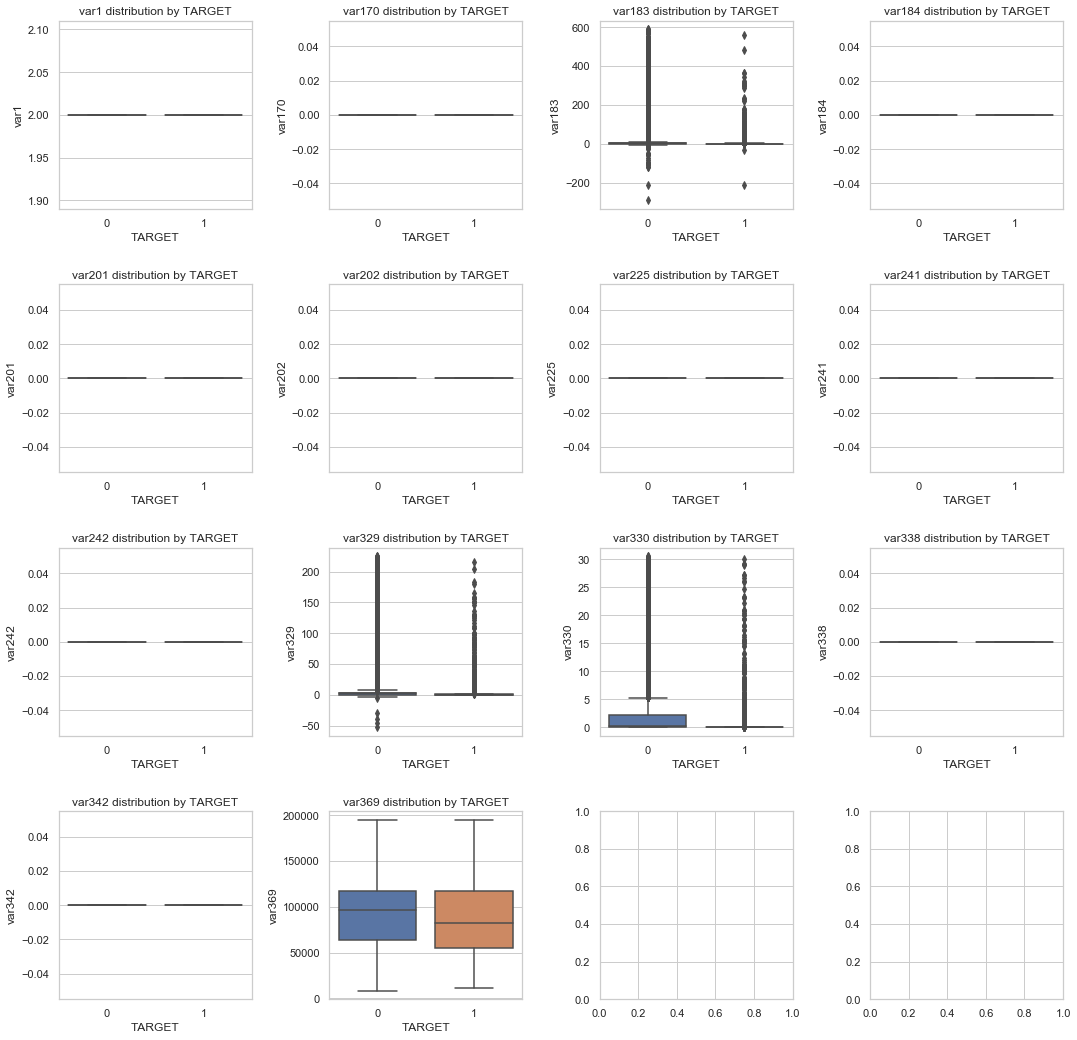

In [95]:
# Checking distribution of variables grouped by the target variable (satisfaction)
fig, axs = plt.subplots(ncols=4, nrows=4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(18, 18, forward=True)
df = df_train_iqr

count = 0

for i in range(4):
    for j in range(4):
        plt.sca(ax=axs[i][j])
        if count < 14:
            col = df.columns[count]
            #sns.boxplot(x="a", hue="b", y="c", data=df_long)
            sns.boxplot(y=col, x="TARGET", data = df).set_title(col +' distribution by TARGET')
        else:
            break
            
        count +=1